In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import dask.array as da

In [10]:
# Define the paths to the datasets
sim_subset_path = '//home/walimunige.rupasingh/pbhmCourse_student/4_high_performance_computing/output/camels_nldas_subset.nc'
sim_full_path = '//home/walimunige.rupasingh/pbhmCourse_student/4_high_performance_computing/output/camels_nldas_full.nc'
coords_path = '/home/walimunige.rupasingh/pbhmCourse_student/4_high_performance_computing/settings/local_attribute_camels.nc'
output = '/home/walimunige.rupasingh/pbhmCourse_student/4_high_performance_computing/output/'
obs_path = '/home/walimunige.rupasingh/hpc_obs/hcdn_obs_depth.nc'

# Load the streamflow dataset
sim_subset = xr.open_dataset(sim_subset_path)

sim_fullset = xr.open_dataset(sim_full_path) 

# load coordinates
coordinates = xr.open_dataset(coords_path)

# load observations
obs = xr.open_dataset(obs_path)

#print(sim_subset)

In [4]:
#Mean daily duscharge for observations
mean_daily_q_obs = obs['qobs'].mean()

print(mean_daily_q_obs)

<xarray.DataArray 'qobs' ()>
array(1.6239373e-08, dtype=float32)


In [5]:
#Mean daily duscharge for observations
Q5_daily_q_obs = obs['qobs'].quantile(0.05)

print(Q5_daily_q_obs)

<xarray.DataArray 'qobs' ()>
array(1.40981992e-11)
Coordinates:
    quantile  float64 0.05


In [6]:
#Mean daily duscharge for observations
Q95_daily_q_obs = obs['qobs'].quantile(0.95)

print(Q95_daily_q_obs)

<xarray.DataArray 'qobs' ()>
array(7.21177145e-08)
Coordinates:
    quantile  float64 0.95


In [7]:
#Mean daily duscharge for subset
mean_daily_q = sim_subset['averageRoutedRunoff_mean'].mean()

print(mean_daily_q)

<xarray.DataArray 'averageRoutedRunoff_mean' ()>
array(1.16005372e-08)


In [8]:
#runoff_ratio for subset
mean_daily_p = sim_subset['pptrate_mean'].mean()

runoff_ratio = mean_daily_q / mean_daily_p

print(mean_daily_p)
print(runoff_ratio)

<xarray.DataArray 'pptrate_mean' ()>
array(3.05177192e-05)
<xarray.DataArray ()>
array(0.00038012)


In [9]:
#baseflow_index for subset

baseflow = sim_subset['scalarAquiferBaseflow_mean'].mean()

baseflow_ratio = baseflow / mean_daily_q

print(baseflow_ratio)


<xarray.DataArray ()>
array(0.32467591)


In [10]:
#Mean daily duscharge for fullset
mean_daily_q_full = sim_fullset['averageRoutedRunoff_mean'].mean()

print(mean_daily_q_full)

<xarray.DataArray 'averageRoutedRunoff_mean' ()>
array(1.26854657e-08)


In [11]:
#runoff_ratio for fullset
mean_daily_p_full = sim_fullset['pptrate_mean'].mean()

runoff_ratio_full = mean_daily_q_full / mean_daily_p_full

print(mean_daily_p_full)
print(runoff_ratio_full)

<xarray.DataArray 'pptrate_mean' ()>
array(3.48728727e-05)
<xarray.DataArray ()>
array(0.00036376)


In [12]:
#baseflow_index for fullset

baseflow_full = sim_fullset['scalarAquiferBaseflow_mean'].mean()

baseflow_ratio_full = baseflow_full / mean_daily_q_full

print(baseflow_ratio_full)

<xarray.DataArray ()>
array(0.34824351)


In [24]:
#Get coordinates for each hru
coord = coordinates.to_dataframe().drop(columns=['hru2gruId', 'contourLength',
       'tan_slope', 'mHeight', 'HRUarea', 'elevation', 'downHRUindex', 'slopeTypeIndex', 'soilTypeIndex', 'vegTypeIndex',
       'gruId'])
coord = coord.reset_index()

# Group the dataframe by catchment area
grouped = coord.groupby('hruId',as_index=False)

# Define a function to filter latitude and longitude values for each catchment area
def filter_lat_lon(group):
    # Assuming latitude is stored in 'lat' column and longitude is stored in 'lon' column
    # You can replace 'lat' and 'lon' with your actual column names
    filtered_data = group[['hruId','latitude', 'longitude']].drop_duplicates()  # Assuming each catchment has multiple entries
    return filtered_data

# Apply the function to each group and concatenate the results
filtered_data = grouped.apply(filter_lat_lon).reset_index(drop=True)

print(filtered_data)

        hruId   latitude   longitude
0     1013500  47.012001  -68.564787
1     1022500  44.797347  -68.072487
2     1030500  45.805514  -68.150311
3     1031500  45.236129  -69.577952
4     1047000  44.988448  -70.162172
..        ...        ...         ...
666  14309500  42.826303 -123.740506
667  14316700  43.454299 -122.648674
668  14325000  42.787407 -124.029755
669  14362250  42.187500 -123.126166
670  14400000  42.236142 -124.005982

[671 rows x 3 columns]


/tmp/ipykernel_694481/1984496139.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_data = grouped.apply(filter_lat_lon).reset_index(drop=True)


In [25]:
geometry_catchment = [Point(lon, lat) for lon, lat in zip(filtered_data['longitude'], filtered_data['latitude'])]

# Create a GeoDataFrame from the DataFrame and the geometry column
gdf_catchment = gpd.GeoDataFrame(filtered_data, geometry=geometry_catchment).reset_index()

# Set the coordinate reference system (CRS) for the GeoDataFrame (Example: WGS 84)
gdf_catchment.crs = "EPSG:4326"


display(gdf_catchment,10)

,index,hruId,latitude,longitude,geometry
0,0,1013500,47.012001,-68.564787,POINT (-68.56479 47.01200)
1,1,1022500,44.797347,-68.072487,POINT (-68.07249 44.79735)
2,2,1030500,45.805514,-68.150311,POINT (-68.15031 45.80551)
3,3,1031500,45.236129,-69.577952,POINT (-69.57795 45.23613)
4,4,1047000,44.988448,-70.162172,POINT (-70.16217 44.98845)
...,...,...,...,...,...
666,666,14309500,42.826303,-123.740506,POINT (-123.74051 42.82630)
667,667,14316700,43.454299,-122.648674,POINT (-122.64867 43.45430)
668,668,14325000,42.787407,-124.029755,POINT (-124.02975 42.78741)
669,669,14362250,42.187500,-123.126166,POINT (-123.12617 42.18750)


10

In [26]:
# Calculate average for each hru_id
q_avg = sim_fullset[[ 'averageRoutedRunoff_mean', 'pptrate_mean', 'scalarAquiferBaseflow_mean']].mean(dim='time')

display(q_avg, 10)

<xarray.Dataset>
Dimensions:                     (gru: 672, hru: 672)
Coordinates:
  * hru                         (hru) int64 1013500 1022500 ... 14400000
  * gru                         (gru) int64 1013500 1022500 ... 14400000
Data variables:
    averageRoutedRunoff_mean    (gru) float64 1.155e-08 1.783e-08 ... 6.168e-08
    pptrate_mean                (hru) float64 3.273e-05 3.72e-05 ... 8.429e-05
    scalarAquiferBaseflow_mean  (hru) float64 1.006e-08 1.065e-08 ... 2.031e-08

10

In [27]:
# Convert xarray Dataset to pandas DataFrame
q_avg_df = q_avg.to_dataframe().reset_index()
print(q_avg_df)

             gru       hru  averageRoutedRunoff_mean  pptrate_mean  \
0        1013500   1013500              1.155380e-08      0.000033   
1        1013500   1022500              1.155380e-08      0.000037   
2        1013500   1030500              1.155380e-08      0.000037   
3        1013500   1031500              1.155380e-08      0.000038   
4        1013500   1047000              1.155380e-08      0.000040   
...          ...       ...                       ...           ...   
451579  14400000  14309500              6.168024e-08      0.000045   
451580  14400000  14316700              6.168024e-08      0.000045   
451581  14400000  14325000              6.168024e-08      0.000071   
451582  14400000  14362250              6.168024e-08      0.000025   
451583  14400000  14400000              6.168024e-08      0.000084   

        scalarAquiferBaseflow_mean  
0                     1.005969e-08  
1                     1.065063e-08  
2                     7.674556e-09  
3          

In [28]:
q_catchment = q_avg_df.groupby(['hru'])[['averageRoutedRunoff_mean', 'pptrate_mean', 'scalarAquiferBaseflow_mean']].mean()
display(q_catchment,10)

,averageRoutedRunoff_mean,pptrate_mean,scalarAquiferBaseflow_mean
hru,,,
1013500,1.268547e-08,0.000033,1.005969e-08
1022500,1.268547e-08,0.000037,1.065063e-08
1030500,1.268547e-08,0.000037,7.674556e-09
1031500,1.268547e-08,0.000038,5.101138e-09
1047000,1.268547e-08,0.000040,7.381193e-09
...,...,...,...
14309500,1.268547e-08,0.000045,2.394421e-09
14316700,1.268547e-08,0.000045,4.876042e-09
14325000,1.268547e-08,0.000071,3.729569e-09


10

In [10]:
# Merge the dataframes using different column names
merged_df = pd.merge(gdf_catchment, q_catchment, left_on='hruId', right_on='hru', how='left')

# Create a geometry column with Point objects
geometry = [Point(lon, lat) for lon, lat in zip(merged_df['longitude'], merged_df['latitude'])]

# Create a GeoDataFrame from the DataFrame and the geometry column
catchment_gdf = gpd.GeoDataFrame(merged_df, geometry=geometry, crs="EPSG:4326")


#calculate ruoff ratio
catchment_gdf['runoff_ratio'] = catchment_gdf['averageRoutedRunoff_mean']/catchment_gdf['pptrate_mean']

#calculate baseflow ratio
catchment_gdf['basefolw_ratio'] = catchment_gdf['averageRoutedRunoff_mean']/catchment_gdf['scalarAquiferBaseflow_mean']

print(catchment_gdf.columns)
print(catchment_gdf)

Index(['index', 'hruId', 'latitude', 'longitude', 'geometry',
       'averageRoutedRunoff_mean', 'pptrate_mean',
       'scalarAquiferBaseflow_mean', 'runoff_ratio', 'basefolw_ratio'],
      dtype='object')
     index     hruId   latitude   longitude                     geometry  \
0        0   1013500  47.012001  -68.564787   POINT (-68.56479 47.01200)   
1        1   1022500  44.797347  -68.072487   POINT (-68.07249 44.79735)   
2        2   1030500  45.805514  -68.150311   POINT (-68.15031 45.80551)   
3        3   1031500  45.236129  -69.577952   POINT (-69.57795 45.23613)   
4        4   1047000  44.988448  -70.162172   POINT (-70.16217 44.98845)   
..     ...       ...        ...         ...                          ...   
666    666  14309500  42.826303 -123.740506  POINT (-123.74051 42.82630)   
667    667  14316700  43.454299 -122.648674  POINT (-122.64867 43.45430)   
668    668  14325000  42.787407 -124.029755  POINT (-124.02975 42.78741)   
669    669  14362250  42.187500 -

/tmp/ipykernel_685818/2335862274.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


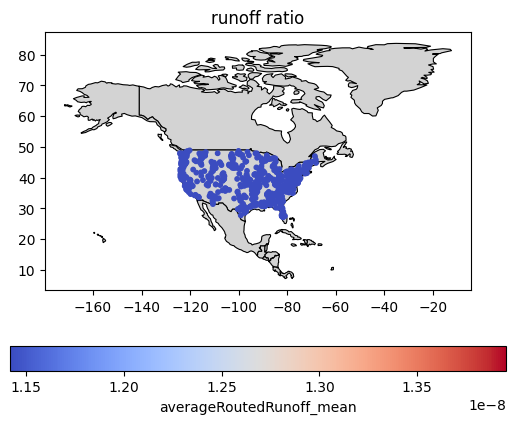

In [50]:
# Load built-in Geopandas dataset
#display(gpd.datasets.available)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Select US
us = world[world['continent'] == 'North America']


fig, ax = plt.subplots(1,1)

# Plot North America as the background
us.plot(ax=ax, linewidth=0.8, color='lightgray',edgecolor='black')

# Set aspect ratio manually
ax.set_aspect('equal')


# Then superimpose the points on top of the North America map
catchment_gdf.plot(column='averageRoutedRunoff_mean', ax=ax, legend=True, markersize=10, cmap='coolwarm',
         legend_kwds={'label': 'averageRoutedRunoff_mean', 'orientation': 'horizontal'})

plt.title('runoff ratio')
#plt.savefig('mean.png')
plt.show()

/tmp/ipykernel_685818/2679556980.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


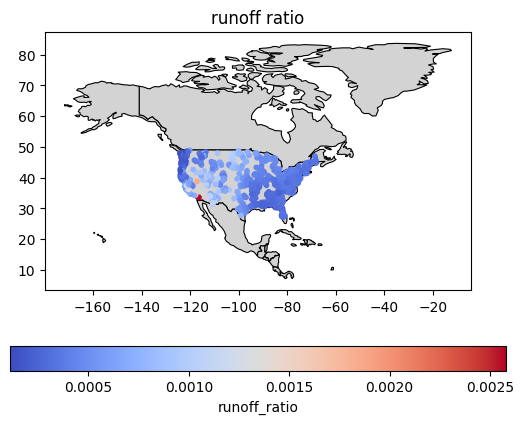

In [49]:
# Load built-in Geopandas dataset
#display(gpd.datasets.available)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Select US
us = world[world['continent'] == 'North America']


fig, ax = plt.subplots(1,1)

# Plot North America as the background
us.plot(ax=ax, linewidth=0.8, color='lightgray',edgecolor='black')

# Set aspect ratio manually
ax.set_aspect('equal')


# Then superimpose the points on top of the North America map
catchment_gdf.plot(column='runoff_ratio', ax=ax, legend=True, markersize=10, cmap='coolwarm',
         legend_kwds={'label': 'runoff_ratio', 'orientation': 'horizontal'})

plt.title('runoff ratio')
#plt.savefig('mean.png')
plt.show()

/tmp/ipykernel_685818/4274950308.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


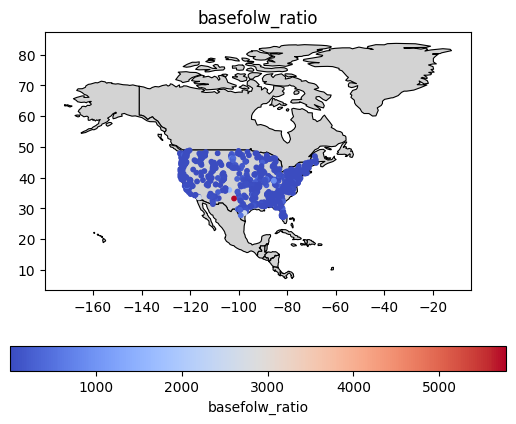

In [51]:
# Load built-in Geopandas dataset
#display(gpd.datasets.available)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Select US
us = world[world['continent'] == 'North America']


fig, ax = plt.subplots(1,1)

# Plot North America as the background
us.plot(ax=ax, linewidth=0.8, color='lightgray',edgecolor='black')

# Set aspect ratio manually
ax.set_aspect('equal')


# Then superimpose the points on top of the North America map
catchment_gdf.plot(column='basefolw_ratio', ax=ax, legend=True, markersize=10, cmap='coolwarm',
         legend_kwds={'label': 'basefolw_ratio', 'orientation': 'horizontal'})

plt.title('basefolw_ratio')
#plt.savefig('mean.png')
plt.show()

In [12]:
# Make Animation
q_avg_anim = sim_fullset[[ 'time','averageRoutedRunoff_mean', 'pptrate_mean', 'scalarSWE']].mean(dim='gru')

q_avg_anim_df = q_avg_anim.to_dataframe().reset_index()
q_avg_anim_df.to_csv(output+ "animation_df.csv")

#q_catchment = sim_fullset.groupby(['time','hru'])[['averageRoutedRunoff_mean', 'pptrate_mean', 'scalarSWE']].mean()
display(q_avg_anim_df,10)

,time,hru,averageRoutedRunoff_mean,pptrate_mean,scalarSWE
0,1988-01-02,1013500,1.815912e-09,0.000000e+00,38.181142
1,1988-01-02,1022500,1.815912e-09,1.585221e-06,37.878634
2,1988-01-02,1030500,1.815912e-09,3.180481e-06,26.994004
3,1988-01-02,1031500,1.815912e-09,4.584163e-07,94.215834
4,1988-01-02,1047000,1.815912e-09,8.416994e-07,73.317007
...,...,...,...,...,...
7608379,2018-12-31,14309500,3.457295e-08,1.435584e-04,0.000000
7608380,2018-12-31,14316700,3.457295e-08,1.200674e-04,0.000465
7608381,2018-12-31,14325000,3.457295e-08,1.465382e-04,0.000000
7608382,2018-12-31,14362250,3.457295e-08,3.094888e-05,0.000000


10

In [29]:
read_csv = pd.read_csv(output+"animation_df.csv").reset_index(0)
read_csv_filter = read_csv.loc[read_csv['time'] == '1988-01-02']

merged_df_anim = pd.merge(gdf_catchment, read_csv_filter, left_on='hruId', right_on='hru', how='left')

display (merged_df_anim,10)

,index_x,hruId,latitude,longitude,geometry,index_y,Unnamed: 0,time,hru,averageRoutedRunoff_mean,pptrate_mean,scalarSWE
0,0,1013500,47.012001,-68.564787,POINT (-68.56479 47.01200),0,0,1988-01-02,1013500,1.815912e-09,0.000000e+00,38.181142
1,1,1022500,44.797347,-68.072487,POINT (-68.07249 44.79735),1,1,1988-01-02,1022500,1.815912e-09,1.585221e-06,37.878634
2,2,1030500,45.805514,-68.150311,POINT (-68.15031 45.80551),2,2,1988-01-02,1030500,1.815912e-09,3.180481e-06,26.994004
3,3,1031500,45.236129,-69.577952,POINT (-69.57795 45.23613),3,3,1988-01-02,1031500,1.815912e-09,4.584163e-07,94.215834
4,4,1047000,44.988448,-70.162172,POINT (-70.16217 44.98845),4,4,1988-01-02,1047000,1.815912e-09,8.416994e-07,73.317007
...,...,...,...,...,...,...,...,...,...,...,...,...
667,666,14309500,42.826303,-123.740506,POINT (-123.74051 42.82630),667,667,1988-01-02,14309500,1.815912e-09,0.000000e+00,1.833590
668,667,14316700,43.454299,-122.648674,POINT (-122.64867 43.45430),668,668,1988-01-02,14316700,1.815912e-09,0.000000e+00,23.187244
669,668,14325000,42.787407,-124.029755,POINT (-124.02975 42.78741),669,669,1988-01-02,14325000,1.815912e-09,0.000000e+00,0.000000
670,669,14362250,42.187500,-123.126166,POINT (-123.12617 42.18750),670,670,1988-01-02,14362250,1.815912e-09,3.847523e-08,0.050707


10

/tmp/ipykernel_694481/2711235918.py:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


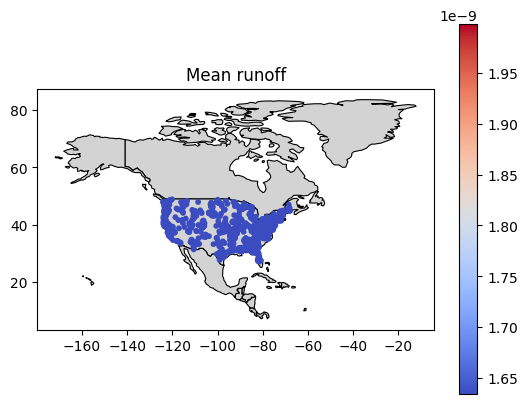

In [35]:
# Load built-in Geopandas dataset

#merge_df_anim['geometry'] = merg_df_anim['geometry'].apply(wkt.loads)
#gdf = gpd.GeoDataFrame(df, geometry='geometry')

#display(gpd.datasets.available)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Select US
us = world[world['continent'] == 'North America']


fig, ax = plt.subplots(1,1)

# Plot North America as the background
us.plot(ax=ax, linewidth=0.8, color='lightgray',edgecolor='black')

# Set aspect ratio manually
ax.set_aspect('equal')


# Then superimpose the points on top of the North America map
merged_df_anim.plot(column='averageRoutedRunoff_mean', ax=ax, legend=True, markersize=10, cmap='coolwarm')
         
plt.title('Mean runoff')
#plt.savefig('mean.png')
plt.show()

,geometry,time,averageRoutedRunoff_mean,pptrate_mean,scalarSWE
4383,POINT (-68.56478698373036 47.0120011970304),2000-01-02,7.731817e-09,0.000003,22.603003
15705,POINT (-68.07248728731587 44.797347109137796),2000-01-02,7.731817e-09,0.000000,0.362100
27027,POINT (-68.15031096168407 45.80551415254027),2000-01-02,7.731817e-09,0.000000,1.700798
38349,POINT (-69.57795198947241 45.23612859615723),2000-01-02,7.731817e-09,0.000000,33.348172
49671,POINT (-70.16217207109301 44.98844796521296),2000-01-02,7.731817e-09,0.000000,22.812218
...,...,...,...,...,...
7556157,POINT (-123.74050633648471 42.82630336437039),2000-01-02,7.731817e-09,0.000148,0.000000
7567479,POINT (-122.64867373791786 43.45429912182024),2000-01-02,7.731817e-09,0.000245,6.392487
7578801,POINT (-124.02975488150916 42.78740739433157),2000-01-02,7.731817e-09,0.000213,0.000000
7590123,POINT (-123.12616632667708 42.1875),2000-01-02,7.731817e-09,0.000047,0.000000


10

/var/folders/g6/d7zppkyj7g98fd6kn97dkcq40000gn/T/ipykernel_2309/2483645111.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  read_csv_filter['geometry'] = read_csv_filter['geometry'].apply(wkt_loads)
/var/folders/g6/d7zppkyj7g98fd6kn97dkcq40000gn/T/ipykernel_2309/2483645111.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/var/folders/g6/d7zppkyj7g98fd6kn97dkcq40000gn/T/ipykernel_2309/2483645111.py:17: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You

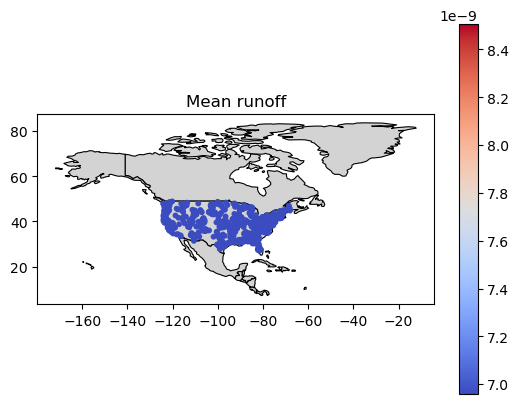

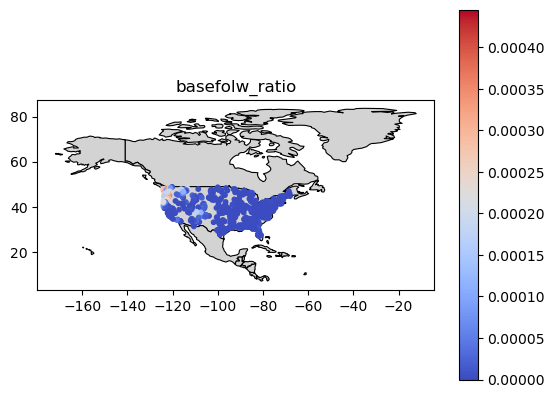

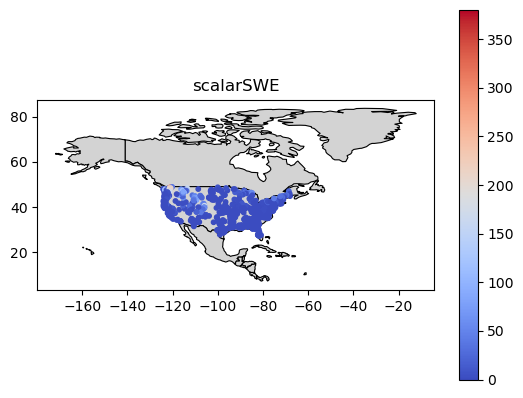

In [8]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.wkt import loads as wkt_loads
import os


def read_and_merge_data( read_csv, time_filter):
    read_csv_filter = pd.DataFrame(columns=read_csv.columns)
    read_csv_filter = read_csv.loc[read_csv['time'] == time_filter]
    display(read_csv_filter,10)
    read_csv_filter['geometry'] = read_csv_filter['geometry'].apply(wkt_loads)
    return gpd.GeoDataFrame(read_csv_filter, geometry='geometry')


def plot_runoff(df,time_filter,column_plot,pltsaveloc):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    us = world[world['continent'] == 'North America']
    fig, ax = plt.subplots(1, 1)
    us.plot(ax=ax, linewidth=0.8, color='lightgray', edgecolor='black')
    ax.set_aspect('equal')
    if column_plot == 'averageRoutedRunoff_mean':
        df.plot(column='averageRoutedRunoff_mean', ax=ax, legend=True, markersize=10, cmap='coolwarm')
        plt.title('Mean runoff')
        plt.savefig(pltsaveloc+time_filter+'_mean.png')
        #plt.show()
    elif column_plot == 'pptrate_mean':
        df.plot(column='pptrate_mean', ax=ax, legend=True, markersize=10, cmap='coolwarm')
        plt.title('basefolw_ratio')
        plt.savefig(pltsaveloc+time_filter+'_baseflow.png')
        #plt.show()
    elif column_plot == 'scalarSWE':
        df.plot(column='scalarSWE', ax=ax, legend=True, markersize=10, cmap='coolwarm')
        plt.title('scalarSWE')
        plt.savefig(pltsaveloc+time_filter+'_swe.png')
        #plt.show()
        
        


#output = '/home/walimunige.rupasingh/pbhmCourse_student/4_high_performance_computing/output/'
#pltsaveloc = '/home/walimunige.rupasingh/pbhmCourse_student/4_high_performance_computing/plot/'

output = '/Users/hasithaj/PycharmProjects/FROSTBYTE/capstone_data/data/'
pltsaveloc = '/Users/hasithaj/PycharmProjects/FROSTBYTE/capstone_data/plot/'

read_csv = pd.read_csv(output + "animation_df.csv").reset_index()
gdf_catchment = pd.read_csv(output + "gdf_catchment_df.csv").reset_index()
merged_df = pd.merge(gdf_catchment, read_csv, left_on='hruId', right_on='hru', how='left')
merged_df = merged_df.drop(columns=['Unnamed: 0_x','index_x','hruId','level_0','latitude','longitude','index_y','Unnamed: 0_y','hru',])

#display(merged_df,10)

time_filter = '2000-01-02'
column_plot = ''
gdf = read_and_merge_data(merged_df, time_filter)
plot_runoff(gdf,time_filter,'averageRoutedRunoff_mean',pltsaveloc)
plot_runoff(gdf,time_filter,'pptrate_mean',pltsaveloc)
plot_runoff(gdf,time_filter,'scalarSWE',pltsaveloc)

/var/folders/g6/d7zppkyj7g98fd6kn97dkcq40000gn/T/ipykernel_2309/1493968736.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  read_csv_filter['geometry'] = read_csv_filter['geometry'].apply(wkt_loads)
/var/folders/g6/d7zppkyj7g98fd6kn97dkcq40000gn/T/ipykernel_2309/1493968736.py:21: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


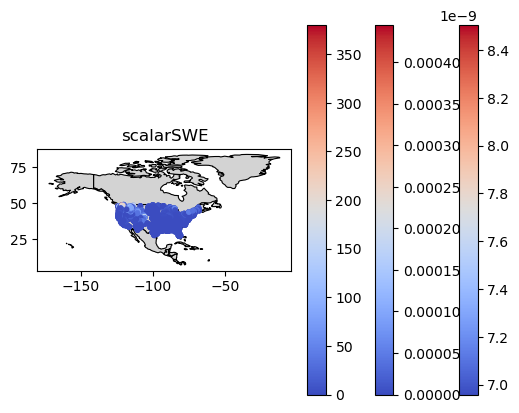

In [11]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.wkt import loads as wkt_loads


def read_and_merge_data(read_csv, time_filter):
    read_csv_filter = read_csv.loc[read_csv['time'] == time_filter]
    read_csv_filter['geometry'] = read_csv_filter['geometry'].apply(wkt_loads)
    return gpd.GeoDataFrame(read_csv_filter, geometry='geometry')


def plot_data(df, column_plot, ax, pltsaveloc, time_filter):
    df.plot(column=column_plot, ax=ax, legend=True, markersize=10, cmap='coolwarm')
    plt.title(column_plot)
    plt.savefig(pltsaveloc + time_filter + '_' + column_plot + '.png')


def plot_runoff(df, time_filter, pltsaveloc):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    us = world[world['continent'] == 'North America']
    fig, ax = plt.subplots(1, 1)
    us.plot(ax=ax, linewidth=0.8, color='lightgray', edgecolor='black')
    ax.set_aspect('equal')

    columns_to_plot = ['averageRoutedRunoff_mean', 'pptrate_mean', 'scalarSWE']
    for column_plot in columns_to_plot:
        plot_data(df, column_plot, ax, pltsaveloc, time_filter)


# File paths
output = '/Users/hasithaj/PycharmProjects/FROSTBYTE/capstone_data/data/'
pltsaveloc = '/Users/hasithaj/PycharmProjects/FROSTBYTE/capstone_data/plot/'


read_csv = pd.read_csv(output + "animation_df.csv").reset_index()
gdf_catchment = pd.read_csv(output + "gdf_catchment_df.csv").reset_index()
merged_df = pd.merge(gdf_catchment, read_csv, left_on='hruId', right_on='hru', how='left')


cols_to_drop = ['Unnamed: 0_x', 'index_x', 'hruId', 'level_0', 'latitude',
                'longitude', 'index_y', 'Unnamed: 0_y', 'hru']
merged_df = merged_df.drop(columns=cols_to_drop)


#time_filter = '2000-01-02'
gdf = read_and_merge_data(merged_df, time_filter)
plot_runoff(gdf, time_filter, pltsaveloc)



In [21]:
len(merged_df['time'].unique())

11322

In [24]:
merged_df['time'].max

<bound method Series.max of 0          1988-01-02
1          1988-01-03
2          1988-01-04
3          1988-01-05
4          1988-01-06
              ...    
7608379    2018-12-27
7608380    2018-12-28
7608381    2018-12-29
7608382    2018-12-30
7608383    2018-12-31
Name: time, Length: 7608384, dtype: object>

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.wkt import loads as wkt_loads


def read_and_merge_data(read_csv, time_filter):
    read_csv_filter = read_csv.loc[read_csv['time'] == time_filter]
    read_csv_filter['geometry'] = read_csv_filter['geometry'].apply(wkt_loads)
    return gpd.GeoDataFrame(read_csv_filter, geometry='geometry')


def plot_data(df, column_plot, ax, pltsaveloc, time_filter):
    df.plot(column=column_plot, ax=ax, legend=True, markersize=10, cmap='coolwarm')
    plt.title(column_plot)
    plt.savefig(pltsaveloc + time_filter + '_' + column_plot + '.png')


def plot_runoff(df, time_filter, pltsaveloc):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    us = world[world['continent'] == 'North America']
    fig, ax = plt.subplots(1, 1)
    us.plot(ax=ax, linewidth=0.8, color='lightgray', edgecolor='black')
    ax.set_aspect('equal')

    columns_to_plot = ['averageRoutedRunoff_mean', 'pptrate_mean', 'scalarSWE']
    for column_plot in columns_to_plot:
        plot_data(df, column_plot, ax, pltsaveloc, time_filter)


# File paths
output = '/Users/hasithaj/PycharmProjects/FROSTBYTE/capstone_data/data/'
pltsaveloc = '/Users/hasithaj/PycharmProjects/FROSTBYTE/capstone_data/plot/'


read_csv = pd.read_csv(output + "animation_df.csv").reset_index()
gdf_catchment = pd.read_csv(output + "gdf_catchment_df.csv").reset_index()
merged_df = pd.merge(gdf_catchment, read_csv, left_on='hruId', right_on='hru', how='left')


cols_to_drop = ['Unnamed: 0_x', 'index_x', 'hruId', 'level_0', 'latitude',
                'longitude', 'index_y', 'Unnamed: 0_y', 'hru']
merged_df = merged_df.drop(columns=cols_to_drop)


#time_filter = '2000-01-02'
gdf = read_and_merge_data(merged_df, time_filter)
plot_runoff(gdf, time_filter, pltsaveloc)